Impordime eeltöödeldud andmed ja treenime Random Forestit (esialgu suvaliste parameetritega)

In [1]:
import pandas as pd
import numpy as np
X_train = pd.read_csv('X_train_sub.csv')
X_train.drop(columns='Unnamed: 0', inplace=True)
y_train = pd.read_csv('y_train_sub.csv')

from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=16, max_depth=4, random_state=11).fit(X_train, y_train)

Impordime varasemalt eraldatud valideerimisandmestiku ja prognoosime tõenäosused selle peal

In [2]:
X_val = pd.read_csv('X_val.csv')
X_val.drop(columns='Unnamed: 0', inplace=True)
y_val = pd.read_csv('y_val.csv')
y_val = y_val.y

probs = rf.predict_proba(X_val)[1]
assert np.isclose(probs.sum(axis=1), 1).all() # check that all rows sum up to 1

probs = pd.DataFrame(probs, columns=['a', 'b']) # Store in pandas Dataframe with two columns
probs = probs.b # Keep only one column (store as a pandas Series)

probs

0       0.136952
1       0.211811
2       0.155964
3       0.693278
4       0.624784
          ...   
7652    0.207595
7653    0.476757
7654    0.515501
7655    0.436619
7656    0.233758
Name: b, Length: 7657, dtype: float64

Tekitame lävendite (*cutoff*) järjendi. Kuna kümnete tuhandete kirjete puhul pole mõtet võtta sellesse kõiki võimalikke ennustatud tõenäosusi, võtame need sammuga 0,5 protsendipunkti.

In [3]:
cutoffs = pd.DataFrame({'cutoff':np.arange(0.005,1,0.005)}) 
cutoffs

,cutoff
0,0.005
1,0.010
2,0.015
3,0.020
4,0.025
...,...
194,0.975
195,0.980
196,0.985
197,0.990


Arvutame *TPR* ja *FPR* indeksid ja *accuracy* iga lävendi puhul:

In [4]:
tpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut.iloc[0], y_val == 1)) / np.sum(y_val == 1), axis=1)
fpr = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut.iloc[0], y_val == 0)) / np.sum(y_val == 0), axis=1)

stats = pd.DataFrame({'cutoff':cutoffs.cutoff, 'tpr':tpr, 'fpr':fpr})

tp_count = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut.values[0], y_val == 1)), axis=1)
fp_count = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs >= cut.values[0], y_val == 0)), axis=1)
tn_count = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs < cut.values[0], y_val == 0)), axis=1)
fn_count = cutoffs.apply(lambda cut: np.sum(np.logical_and(probs < cut.values[0], y_val == 1)), axis=1)

stats['tp_count'] = tp_count
stats['fp_count'] = fp_count
stats['tn_count'] = tn_count
stats['fn_count'] = fn_count
stats['accuracy'] = (stats['tp_count'] + stats['tn_count']) / len(probs)
stats['precision'] = stats['tp_count'] / (stats['tp_count'] + stats['fp_count'])
stats['recall'] = stats['tp_count'] / (stats['tp_count'] + stats['fn_count'])

Leiame parimad väärtused:

In [5]:
cutoff1 = stats.accuracy.idxmax(axis=0, skipna=True)
print('Max accuracy: ', stats.loc[cutoff1]['accuracy'], 
      ' ( cutoff ', stats.loc[cutoff1]['cutoff'], ', precision ', stats.loc[cutoff1]['precision'], ')\n')

cutoff2 = stats.precision.idxmax(axis=0, skipna=True)
print('Max precision: ', stats.loc[cutoff2]['precision'],
      ' ( cutoff ', stats.loc[cutoff2]['cutoff'], ', accuracy ', stats.loc[cutoff2]['accuracy'], ')\n')


Max accuracy:  0.8874232728222542  ( cutoff  0.435 , precision  0.855552867166707 )

Max precision:  1.0  ( cutoff  0.9 , accuracy  0.5055504766879979 )



Tekitame *ROC* kõvera:

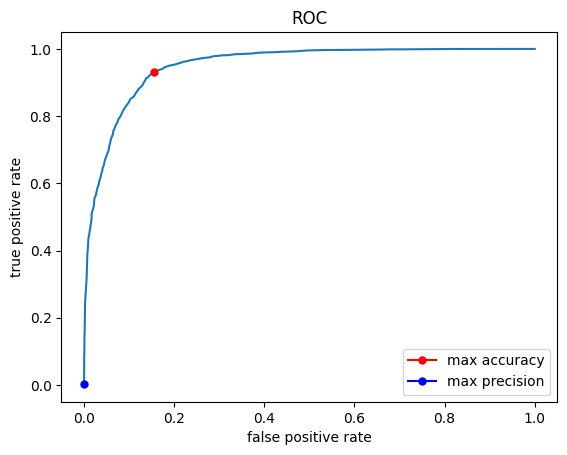

In [6]:
import matplotlib.pyplot as plt
plt.title("ROC")
plt.plot(stats['fpr'], stats['tpr'])
plt.plot(stats.loc[cutoff1]['fpr'], stats.loc[cutoff1]['tpr'], color='red', marker='o', markersize=5, label="max accuracy")
plt.plot(stats.loc[cutoff2]['fpr'], stats.loc[cutoff2]['tpr'], color='blue', marker='o', markersize=5, label="max precision")
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.legend()
plt.show()

In [7]:
kaggle_test = pd.read_csv('test_cleaner2.csv')
kaggle_test.drop(columns=['Name'], inplace=True)

Prognoosime Kaggle'i test-andmestiku tulemused (<font color='red'>kuna kogu andmestiku korraga töötlemine annab mälu-*error*'i, siis töötleme osade kaupa</font>):

In [8]:
kaggle_probs = pd.Series()
for i in range(len(kaggle_test) // 10000 + 1):
    a = i * 10000
    b = min(a + 10000, len(kaggle_test))
    kaggle_probs_sub = rf.predict_proba(kaggle_test[a:b])[1]
    assert np.isclose(kaggle_probs_sub.sum(axis=1), 1).all() # check that all rows sum up to 1
    
    kaggle_probs_sub = pd.DataFrame(kaggle_probs_sub, columns=['a', 'b']) # Store in pandas Dataframe with two columns
    kaggle_probs_sub = kaggle_probs_sub.b # Keep only one column (store as a pandas Series)
    
    kaggle_probs = pd.concat([kaggle_probs, kaggle_probs_sub])
kaggle_probs

C:\Users\ksiim\AppData\Local\Temp\ipykernel_1828\4213796876.py:11: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  kaggle_probs = pd.concat([kaggle_probs, kaggle_probs_sub])


0       0.230719
1       0.210321
2       0.441611
3       0.813055
4       0.333972
          ...   
3795    0.264122
3796    0.634798
3797    0.524880
3798    0.603600
3799    0.258425
Length: 93800, dtype: float64

Vormistame kaggle'i võistluse jaoks sobiva formaadi ja teeme csv:

In [9]:
kaggle_csv = pd.DataFrame(data={'id': kaggle_test.id})
depression = []
for i in range(len(kaggle_probs)):
    if kaggle_probs.iloc[i] >= stats.loc[cutoff1]['accuracy']: depression.append(1)
    else: depression.append(0)
kaggle_csv['Depression'] = depression

kaggle_csv.to_csv('kaggle_csv.csv', index=False)